# Data Wrangling & EDA | Twitter | HK NLP Project

# Table of Contents
* [1.0 Wrangling](#toc)
  * [1.1 Contents](#wrangle_contents)
  * [1.2 Imports & Set Up](#imports)
  * [1.3 Initial Scraping before Regex](#int_scrape)
  * [1.4 Regex](#regex)
     * [1.4.1 Duplicated TorF](#dupe)
     * [1.4.2 Language](#lang)
     * [1.4.3 Mentions to Other Users](#oum)
     * [1.4.4 HTML tags](#htmltags)
     * [1.4.5 Tweet Hashtags](#tweethash_tags)
     * [1.4.6 Emoji's](#emojis)
     * [1.4.7 Profanity](#profanity)
     * [1.4.8 Foreign Languages](#flanguage)
     * [1.4.9 Sentiment Intensity Analyzer](#sia)
     * [1.4.10 Stop Words](#stop_words) 
     * [1.4.11 Stemming](#word_stem) 
     * [1.4.12 Lemmatization](#word_lem) 
     * [1.4.13 Tweet Length](#tweet_length) 
     * [1.4.14 Number of Hashtags](#num_hashtags) 
     * [1.4.15 TfidfVectorizer](#word_v_tfid) 
     * [1.4.16 CountVectorizer](#word_v_count) 
  * [1.5 Putting the Data to the Side](#pts)
* [2.0 Exploratory Data Analysis (EDA)](#eda)
  * [2.1 Contents](#eda_contents)
  * [2.2 xxxxxxxxxxxxxx](#_____)
  * [2.3 xxxxxxxxxxxxxx](#_____)
  * [2.4 xxxxxxxxxxxxxx](#_____)
  * [2.5 xxxxxxxxxxxxxx](#_____)
  * [2.6 xxxxxxxxxxxxxx](#_____)
  * [2.7 xxxxxxxxxxxxxx](#_____)
  * [2.8 xxxxxxxxxxxxxx](#_____)
  * [2.9 xxxxxxxxxxxxxx](#_____)
  * [2.10 Pulling them together](#1.15_ptt)


# **1.1 Contents**<a id='wrangle_contents'></a>

This is where you will summarize your intent. Mention you used `twint`

# **1.2 Imports & Set Up**<a id='imports'></a>

In [14]:
# Main Imports
import os
import sys
import numpy as np
import statistics
from scipy import stats
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
%matplotlib inline
import datetime
import warnings
warnings.filterwarnings("ignore")
%reload_ext watermark
from translate import translator
import googletrans
from googletrans import Translator

# NLP Imports
import re
import string
import nltk
import pickle
import emoji
from better_profanity import profanity
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter
import spacy
nltk.download("stopwords")
stop = stopwords.words('english')
stopwords = nltk.corpus.stopwords.words('english')
ps= nltk.PorterStemmer()

results = Counter()

# from polyglot.text import Text

# The below 2 may be required
# import nltk
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

# Still importing twint
import twint
import nest_asyncio
nest_asyncio.apply()

%watermark -d -t -v -p pandas

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rands\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pandas: 1.2.4



In [15]:
# Here I am structuring a color scale for heatmaps which will be used later

cdict = {'green':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'red': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)


In [16]:
cd

C:\Users\rands


In [17]:
df = pd.read_excel('./_Capstone_Two_NLP/data/_twitter/tweets.xlsx')
df = df.reset_index()
df = df.drop(columns=['Unnamed: 0','index'])

# **1.3 Initial Scraping before Regex**<a id='int_scrape'></a>

In [18]:
df.head(2)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28 10:23:06 Eastern Daylight Time,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-27 11:15:39 Eastern Daylight Time,dani_tasso,Razzismo e democrazia. Sfaccettature del med...,it,1,0,2,[],"['blacklivesmatter', 'fightforhongkong', 'open..."


In [19]:
len(df)

288416

In [20]:
df.shape

(288416, 10)

**HERE WE WILL LOOK TO ISOLATE THE DATAFRAME TO A SMALLER SUBSET**

In [21]:
df['hash'].value_counts()

#standwithhongkong     165501
#freehongkong           71875
#hkpolicebrutality      17113
#hkpolicestate          16291
#HongKongProtest         8130
#hkpoliceterrorism       3900
#hkprotests              3606
#HKpoliceterrorist        822
#WeAreNotAlone            614
#PrayForHongkong          332
#FightForHongKong         158
#nochinaextradition        74
Name: hash, dtype: int64

In [22]:
df = df.head(350)

In [23]:
len(df)

350

In [24]:
#confirming chinese characteres within
df.tweet[16]

'黄色い横断幕🍋🇭🇰🐈 #Fightforhongkong   #国会前\u3000 #香港を守れ #香港の自由と民主主義のために日本政府の対応を求めます #StandWithHongKong  #HongKong  #FreeAgnes  #国家安全法 #香港🇭🇰  8月12日水曜日\u300018:00〜20:00 国会正門前北側  https://t.co/YNXXCDSIUV'

In [25]:
#confirming emojis within | got them both above
# df.tweet[288411]

In [26]:
df.head(2)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28 10:23:06 Eastern Daylight Time,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-27 11:15:39 Eastern Daylight Time,dani_tasso,Razzismo e democrazia. Sfaccettature del med...,it,1,0,2,[],"['blacklivesmatter', 'fightforhongkong', 'open..."


In [27]:
df['hash'].value_counts()

#HongKongProtest     192
#FightForHongKong    158
Name: hash, dtype: int64

In [28]:
df.reset_index(inplace = True)
df.head(2)

,index,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags
0,0,#FightForHongKong,2020-08-28 10:23:06 Eastern Daylight Time,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,1,#FightForHongKong,2020-08-27 11:15:39 Eastern Daylight Time,dani_tasso,Razzismo e democrazia. Sfaccettature del med...,it,1,0,2,[],"['blacklivesmatter', 'fightforhongkong', 'open..."


**IT'S BEEN CUT BUT WILL BE CUT LATER WITH DUPLICATE REMOVAL**

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           350 non-null    int64 
 1   hash            350 non-null    object
 2   created_at      350 non-null    object
 3   username        350 non-null    object
 4   tweet           350 non-null    object
 5   language        350 non-null    object
 6   replies_count   350 non-null    int64 
 7   retweets_count  350 non-null    int64 
 8   likes_count     350 non-null    int64 
 9   reply_to        350 non-null    object
 10  hashtags        350 non-null    object
dtypes: int64(4), object(7)
memory usage: 30.2+ KB


In [30]:
#this is confirmed above but will double confirm
df.isnull().values.any()

False

**Data Defined**

In this short section, we will highlight what the columns are referring too.

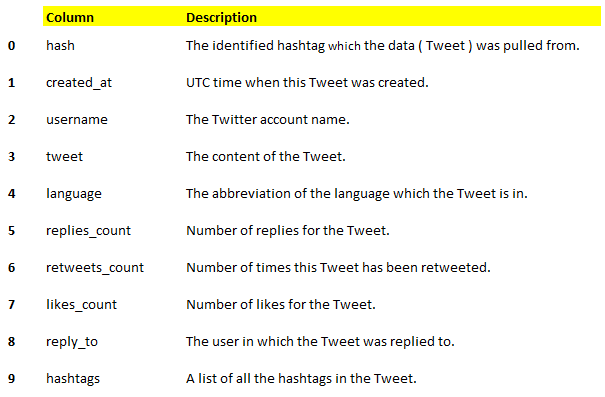

In [31]:
#Range of values per column
df.agg([min,max]).T

,min,max
index,0,349
hash,#FightForHongKong,#HongKongProtest
created_at,2020-06-01 20:22:04 Eastern Daylight Time,2020-08-29 19:36:54 Eastern Daylight Time
username,2pftw,zarcnest
tweet,https://t.co/8lgfzmGtav #lukashenko #Tikhan...,黄色い横断幕🍋🇭🇰🐈 #Fightforhongkong #国会前 #香港を守れ #香...
language,de,zh
replies_count,0,32
retweets_count,0,351
likes_count,0,756
reply_to,[],"[{'screen_name': 'uffeelbaek', 'name': 'Uffe E..."


In [32]:
#Checking for nulls
df.isnull().sum()

index             0
hash              0
created_at        0
username          0
tweet             0
language          0
replies_count     0
retweets_count    0
likes_count       0
reply_to          0
hashtags          0
dtype: int64

In [33]:
#Checking the datatypes
df.dtypes

index              int64
hash              object
created_at        object
username          object
tweet             object
language          object
replies_count      int64
retweets_count     int64
likes_count        int64
reply_to          object
hashtags          object
dtype: object

The `created_at` column is an object; I will convert it to `datetime`.

In [34]:
new_date = df['created_at']
new_date = new_date.str.split(expand=True)
new_date = new_date[0]
new_date = pd.to_datetime(new_date)

In [35]:
df['created_at'] = new_date
df.head(2)

,index,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags
0,0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,1,#FightForHongKong,2020-08-27,dani_tasso,Razzismo e democrazia. Sfaccettature del med...,it,1,0,2,[],"['blacklivesmatter', 'fightforhongkong', 'open..."


In [36]:
df.dtypes

index                      int64
hash                      object
created_at        datetime64[ns]
username                  object
tweet                     object
language                  object
replies_count              int64
retweets_count             int64
likes_count                int64
reply_to                  object
hashtags                  object
dtype: object

In [37]:
#count of unique values for every column, regardless of data type
df.nunique()

index             350
hash                2
created_at         52
username          110
tweet             261
language           12
replies_count       6
retweets_count     11
likes_count        19
reply_to           69
hashtags          120
dtype: int64

The `hash` number looks correct as that's how many hashtags were pulled.

In [38]:
df['hash'].unique()

array(['#FightForHongKong', '#HongKongProtest'], dtype=object)

The `created_at` number also looks correct as **3 months after the implimentation of the law was the range in which the tweets were pulled** .

In [39]:
print('  ',df['created_at'].min(), ' | Beginning', '\n',
     ' ',df['created_at'].max(), ' | End')

   2020-06-01 00:00:00  | Beginning 
   2020-08-29 00:00:00  | End


The `username` number also makes sense.

In [40]:
print('A single user on average tweeted',round(len(df) / len(df['username'].unique()),0), 'times in the course of 3 months.')

A single user on average tweeted 3.0 times in the course of 3 months.


Most of the others aren't important but I believe **the `tweet` number should align with the length of the data frame to ensure there are no duplicates.**

In [41]:
print('There may be', "{:,}".format(len(df) - len(df['tweet'].unique())), 'duplicates to look into.')

There may be 89 duplicates to look into.


We will take a **look at where duplicates** may be found with the **`tweet` column**. Our initial focus is on **when a "tweeter"** (also known a person) **used multiple hashtags**.

A seperate data frame will be used to ensure the original is not compromised.

In [42]:
df_tweets = df.copy()
df_tweets = pd.DataFrame(df_tweets)
len(df_tweets)

350

In [43]:
duplicated_tf = df_tweets.duplicated(subset=['tweet'])
duplicated_tf = pd.DataFrame(duplicated_tf)
len(duplicated_tf)

350

In [44]:
duplicated_tf.columns = ['Duplicated']
duplicated_tf.tail(3)

,Duplicated
347,False
348,False
349,False


In [45]:
num = {True:1,False:0}
duplicated_tf['Duplicated_TorF'] = duplicated_tf['Duplicated'].map(num)
duplicated_tf.tail(3)

,Duplicated,Duplicated_TorF
347,False,0
348,False,0
349,False,0


In [46]:
duplicated_tf = duplicated_tf.drop(columns=['Duplicated'])

In [47]:
df_tweets_w_dup = pd.concat([df_tweets,duplicated_tf],
                    axis = 1, ignore_index=False)
df_tweets_w_dup = df_tweets_w_dup.reset_index(drop=True)

In [48]:
df_tweets_w_dup.tail(2)

,index,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
348,348,#HongKongProtest,2020-08-26,raven05339255,"Blackbloc tomorrow, HKgers reunion! In the dar...",en,0,0,0,[],"['hongkongprotest', 'fightforfreedom', 'standw...",0
349,349,#HongKongProtest,2020-08-26,lhk13975598,#Hongkongprotest,und,0,0,0,[],['hongkongprotest'],0


In [49]:
print(' Ensuring we have the same # of tweets after classification.','\n', 
      round((( ( len(df_tweets_w_dup) / len(df) ) - 1 ) * 100)), '| This should be a Zero change','\n',
     df_tweets_w_dup['Duplicated_TorF'].nunique(), '| The Duplicated Column should have 2 unique values 0,1')

 Ensuring we have the same # of tweets after classification. 
 0 | This should be a Zero change 
 2 | The Duplicated Column should have 2 unique values 0,1


Ok. Let's take a quick look at some of these duplicates.

In [50]:
len(df_tweets_w_dup)

350

In [51]:
df_tweets_w_dup.loc[df_tweets_w_dup['Duplicated_TorF'] == 1].sort_values(by=['tweet'])

,index,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
88,88,#FightForHongKong,2020-08-22,the_lapalissian,https://t.co/8lgfzmGtav #lukashenko #Tikhan...,und,0,1,2,[],"['lukashenko', 'tikhanovskaya', 'minsk', 'figh...",1
100,100,#FightForHongKong,2020-08-04,roller_up_1,https://t.co/B5KWeYZE6t #boycottchina #hongko...,und,0,0,0,[],"['boycottchina', 'hongkong', 'freehk', 'boycot...",1
136,136,#FightForHongKong,2020-06-18,wetruths,#Beijing plans to pass contentious legislation...,en,0,1,0,[],"['beijing', 'chinese', 'hongkong', 'fightforho...",1
131,131,#FightForHongKong,2020-06-29,horea2012,#FightForHongKong #HongKongProtests,und,0,0,0,[],"['fightforhongkong', 'hongkongprotests']",1
116,116,#FightForHongKong,2020-07-06,dhrvptl,#FightForHongKong https://t.co/C5dAXctB7X,und,0,0,1,[],['fightforhongkong'],1
...,...,...,...,...,...,...,...,...,...,...,...,...
156,156,#FightForHongKong,2020-06-02,joshjosetoscano,✊🏽✊🏽✊🏽 #BlackOutTuesday #IndigenousLivesMatter...,und,0,0,1,[],"['blackouttuesday', 'indigenouslivesmatter', '...",1
94,94,#FightForHongKong,2020-08-12,ansumo888,我支持你🇭🇰 #Fightforhongkong #香港加油🇭🇰 #香港を守れ #香港...,ja,1,4,3,[],"['fightforhongkong', '香港加油', '香港を守れ', '香港の自由と民...",1
93,93,#FightForHongKong,2020-08-12,ansumo888,日本も香港の民主主義に関してどーするの？？ #Fightforhongkong #国会前...,ja,0,1,2,[],"['fightforhongkong', '国会前', '香港を守れ', '香港の自由と民主...",1
117,117,#FightForHongKong,2020-07-05,reiwashinsenoen,続 僕の前から君が消えて 胸に広がる切ない思い ぽっかり開いた心の余白 何で満たせばいいの...,ja,1,3,2,[],"['fightforhongkong', 'standwithhongkong']",1


In [52]:
len(df_tweets_w_dup)

350

I would now like to **investigate the languages herein.**

<AxesSubplot:xlabel='Language Abbrevation', ylabel='# of observed Tweets'>

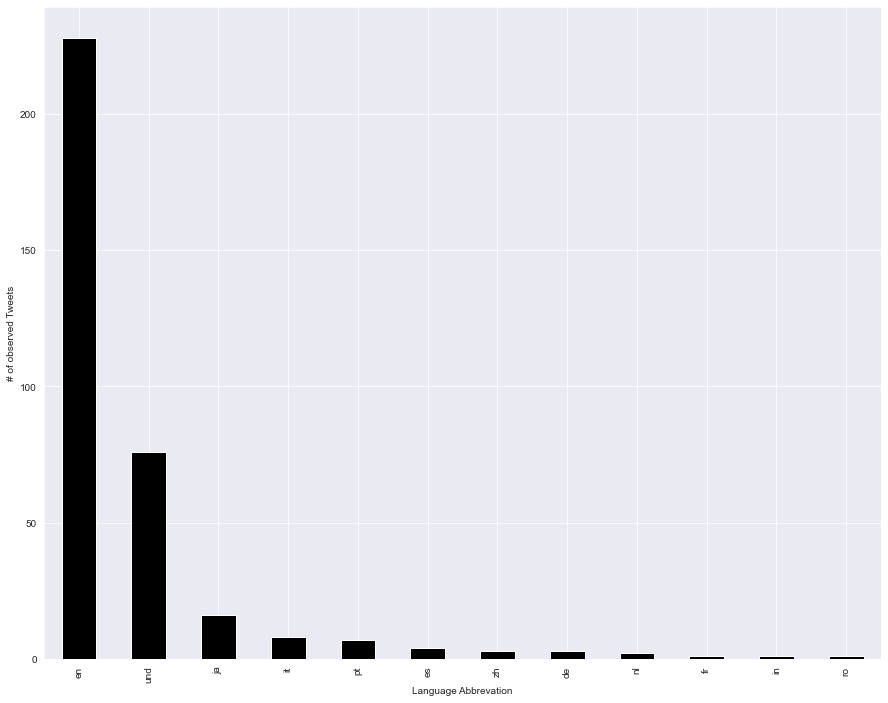

In [53]:
sns.set_style('darkgrid')
lang = pd.value_counts(df_tweets_w_dup['language'].values, sort=True)
lang = lang.sort_values(ascending=False)
plt.subplots(figsize=(15, 12))
plt.ylabel('# of observed Tweets')
plt.xlabel('Language Abbrevation')
lang.plot.bar(color='black')

In [54]:
df_tweets_w_dup['language'].value_counts().head(10)

en     228
und     76
ja      16
it       8
pt       7
es       4
zh       3
de       3
nl       2
fr       1
Name: language, dtype: int64

In [55]:
lang_count = df_tweets_w_dup['language']
round(lang_count.value_counts(normalize=True),2).head()

en     0.65
und    0.22
ja     0.05
it     0.02
pt     0.02
Name: language, dtype: float64

**`en` & `und` is contributing 91%. While `zh`'s (Mandarin Chinese) contribution is only 3%, Mandarin Chinese is important; I will unfortunately have to pass as 3% is unlikely to move the analysis outcome.**

**`und` refers to unknown. I am unsure as to what implications removing would do. Let's see what is "unknown".**

In [56]:
df.reset_index(drop=True)

,index,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags
0,0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,1,#FightForHongKong,2020-08-27,dani_tasso,Razzismo e democrazia. Sfaccettature del med...,it,1,0,2,[],"['blacklivesmatter', 'fightforhongkong', 'open..."
2,2,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
3,3,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
4,4,#FightForHongKong,2020-08-24,cipopolitik,War or communism? https://t.co/V2kQTvR2wr #...,en,0,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf..."
...,...,...,...,...,...,...,...,...,...,...,...
345,345,#HongKongProtest,2020-08-26,firef_ly,香港警察濫權實錄資料庫 https://t.co/ocaGQMDZ0D H.K. Pol...,ja,0,0,0,[],"['hongkongprotest', 'hongkongpoliceterrorism',..."
346,346,#HongKongProtest,2020-08-26,therealhml,#Yellow Lunch 🖐🏻☝🏻#SupportAppleDaily #WeNeedAp...,en,0,0,3,[],"['yellow', 'supportappledaily', 'weneedappleda..."
347,347,#HongKongProtest,2020-08-26,yuen8964,This is totally ridiculous. #CCP #HongKong #...,en,0,0,0,[],"['ccp', 'hongkong', 'hongkongprotest', 'hongko..."
348,348,#HongKongProtest,2020-08-26,raven05339255,"Blackbloc tomorrow, HKgers reunion! In the dar...",en,0,0,0,[],"['hongkongprotest', 'fightforfreedom', 'standw..."


In [57]:
df_tweets_w_dup[df_tweets_w_dup['language'].str.contains('und')]['tweet'].head()

9      https://t.co/8lgfzmGtav   #lukashenko #Tikhan...
17    #FreeAgness #FightForFreedom #StandWithHongKon...
18    #Hongkongers  #hongkong #beijing #china #HongK...
20    #boycottchina #hongkong #freehk #boycottmulan ...
21     https://t.co/B5KWeYZE6t #boycottchina #hongko...
Name: tweet, dtype: object

In [58]:
df_tweets_w_dup[df_tweets_w_dup['language'].str.contains('und')]['tweet']

9       https://t.co/8lgfzmGtav   #lukashenko #Tikhan...
17     #FreeAgness #FightForFreedom #StandWithHongKon...
18     #Hongkongers  #hongkong #beijing #china #HongK...
20     #boycottchina #hongkong #freehk #boycottmulan ...
21      https://t.co/B5KWeYZE6t #boycottchina #hongko...
                             ...                        
337    #StandWithHongKong #FightForFreedom #Standwith...
338    #StandWithHongKong #FightForFreedom #Standwith...
339    #StandWithHongKong #FightForFreedom #Standwith...
342     https://t.co/PhtOU0Xn48 #721YuenLongAttack  #...
349                                     #Hongkongprotest
Name: tweet, Length: 76, dtype: object

In [59]:
# df_tweets_w_dup[df_tweets_w_dup['language'].str.contains('und')]['tweet'][21]

In [60]:
# df_tweets_w_dup[df_tweets_w_dup['language'].str.contains('und')]['tweet'][39]

These appear to be tweets with **only hashtags**; while that may be important & it's contribution is large, **this excerise pertains to the text.**

**Further investigation may be required** at a later date but for now, **we will unfortunately drop them as well & only keep `en`.**

In [61]:
df_tweets_w_dup_en = df_tweets_w_dup[df_tweets_w_dup['language'].str.contains("en")]

In [62]:
df_tweets_w_dup_en.tail()

,index,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
343,343,#HongKongProtest,2020-08-26,faidennis,Thanks Hongkonger in US. @We_the_Hkers #anti...,en,1,0,0,[],"['antielab', 'hongkongprotest', 'hongkong', 'w...",0
344,344,#HongKongProtest,2020-08-26,mcmchoho,#HongKongProtest : Anger mounts as police are ...,en,0,1,1,[],"['hongkongprotest', 'nationalsecuritylaw', 'ho...",0
346,346,#HongKongProtest,2020-08-26,therealhml,#Yellow Lunch 🖐🏻☝🏻#SupportAppleDaily #WeNeedAp...,en,0,0,3,[],"['yellow', 'supportappledaily', 'weneedappleda...",0
347,347,#HongKongProtest,2020-08-26,yuen8964,This is totally ridiculous. #CCP #HongKong #...,en,0,0,0,[],"['ccp', 'hongkong', 'hongkongprotest', 'hongko...",0
348,348,#HongKongProtest,2020-08-26,raven05339255,"Blackbloc tomorrow, HKgers reunion! In the dar...",en,0,0,0,[],"['hongkongprotest', 'fightforfreedom', 'standw...",0


In [63]:
print('There may be', "{:,}".format(len(df) - len(df['tweet'].unique())), 'duplicates to look into.')

There may be 89 duplicates to look into.


In [64]:
print('Review of the # of English articles:','\n'
    '  ',"{:,}".format( len(df_tweets_w_dup[df_tweets_w_dup.language == 'en'])), '| English count before dropping other languages','\n',
     ' ',"{:,}".format(len(df_tweets_w_dup_en)),'| Count after dropping other languages')

Review of the # of English articles: 
   228 | English count before dropping other languages 
   228 | Count after dropping other languages


That matches the above so **we will now remove duplicates.**

In [65]:
df_tweets_wout_dup_en = df_tweets_w_dup_en[df_tweets_w_dup_en['Duplicated_TorF']==0]

Confirming that worked we will bring the data frame that did not delete the duplicates back & see what the sum of the `Duplicates_TorF` column is; as a reminder, **a duplicate has a 1 & the non-Duplicate has a 0.**

In [66]:
sum(df_tweets_w_dup_en['Duplicated_TorF'])

54

So there was ~30k identified duplicates, so what is the length of the dataframe without duplicates.

In [67]:
sum(df_tweets_wout_dup_en['Duplicated_TorF'])

0

In [68]:
duplicated_tf_next = df_tweets_wout_dup_en.duplicated(subset=['tweet'])
duplicated_tf_next = pd.DataFrame(duplicated_tf_next)
duplicated_tf_next.columns = ['Duplicated_check']
duplicated_tf_next.Duplicated_check.unique()

array([False])

**A complete list of False essentially says there are no duplicates.**

In [69]:
len(df_tweets_wout_dup_en)

174

That's yet another cut albeit it's expected given the source in which we are working with.

**We will take a look at what percent of the original total we have left.**

In [70]:
round((( len(df_tweets_wout_dup_en) / len(df) ) * 100),2 )

49.71

**Before sending the Dataframe to Regex, we will hold on to it on the side for reference.**

In [71]:
cd

C:\Users\rands


In [72]:
df_tweets_wout_dup_en.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_tweets_wout_dup_en_short.xlsx')
print('Finished')

Finished


# 1.4 Regex<a id='regex'></a>

Before moving forwards, **we will send the `df_tweets_wout_dup_en` back to it's home ( `df` )** so we don't have to use a long name.

In [73]:
df = df_tweets_wout_dup_en

In [74]:
print('  ',"{:,}".format(len(df_tweets_wout_dup_en)), '| the length of the temp dataframe.','\n',
     ' ', "{:,}".format(len(df)), '| the length of our new dataframe.')

   174 | the length of the temp dataframe. 
   174 | the length of our new dataframe.


In [75]:
df.isnull().sum()

index              0
hash               0
created_at         0
username           0
tweet              0
language           0
replies_count      0
retweets_count     0
likes_count        0
reply_to           0
hashtags           0
Duplicated_TorF    0
dtype: int64

In [76]:
df.head(1)

,index,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
0,0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0


In [77]:
df = df.drop(['index'], axis=1)

In [78]:
df.head(10)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0
2,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
3,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
4,#FightForHongKong,2020-08-24,cipopolitik,War or communism? https://t.co/V2kQTvR2wr #...,en,0,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
5,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
6,#FightForHongKong,2020-08-24,cipopolitik,Read the report today: How to stop China in Ho...,en,0,0,0,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
7,#FightForHongKong,2020-08-23,cipopolitik,China will never stop. #HongKongProtest #Figh...,en,0,0,0,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
8,#FightForHongKong,2020-08-23,cipopolitik,China want to dominate the World Get the rep...,en,1,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
11,#FightForHongKong,2020-08-19,korn_bianca,@StandwithHK_JPN Thank you japan brother and s...,en,0,0,0,"[{'screen_name': 'StandwithHK_JPN', 'name': 'S...","['freehongkong', 'fightforhongkong']",0
12,#FightForHongKong,2020-08-15,frankseier,Joshua Wong: ‘Forms of resistance need to be f...,en,0,0,0,[],"['fightforhongkong', 'hongkongprotest']",0


In [79]:
df = df.reset_index(drop=True)
df.head(10)

,hash,created_at,username,tweet,language,replies_count,retweets_count,likes_count,reply_to,hashtags,Duplicated_TorF
0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...,en,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
3,#FightForHongKong,2020-08-24,cipopolitik,War or communism? https://t.co/V2kQTvR2wr #...,en,0,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
4,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,en,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",0
5,#FightForHongKong,2020-08-24,cipopolitik,Read the report today: How to stop China in Ho...,en,0,0,0,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
6,#FightForHongKong,2020-08-23,cipopolitik,China will never stop. #HongKongProtest #Figh...,en,0,0,0,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
7,#FightForHongKong,2020-08-23,cipopolitik,China want to dominate the World Get the rep...,en,1,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf...",0
8,#FightForHongKong,2020-08-19,korn_bianca,@StandwithHK_JPN Thank you japan brother and s...,en,0,0,0,"[{'screen_name': 'StandwithHK_JPN', 'name': 'S...","['freehongkong', 'fightforhongkong']",0
9,#FightForHongKong,2020-08-15,frankseier,Joshua Wong: ‘Forms of resistance need to be f...,en,0,0,0,[],"['fightforhongkong', 'hongkongprotest']",0


That was already believed but it's good practice to double confirm.

<a id='dupe'></a>**`Duplicated_TorF` | Given we dropped all 1's from the column, we can drop it.** Before, we will double confirm.

In [80]:
np.unique(df['Duplicated_TorF'])

array([0], dtype=int64)

In [81]:
df = df.drop(columns=['Duplicated_TorF'])

<a id='lang'></a>**`language` | We will do the same with `language`**.

In [82]:
np.unique(df['language'])

array(['en'], dtype=object)

In [83]:
df = df.drop(columns=['language'])

<a id='oum'></a>**`Mentions to Other Users` |** We would like to remove from **`tweets`any mentions to other `usernames` which aren't necessary**. Take a **look at:
   * ginny81025554's comment towards @benedictrogers** & **@NOW4humanity** 

**We don't want those words;** we will now **remove mentions to other users.**

In [84]:
df[['hash', 'created_at', 'username', 'tweet']].head(1)

,hash,created_at,username,tweet
0,#FightForHongKong,2020-08-28,ginny81025554,@benedictrogers @NOW4humanity Thanks for speak...


In [85]:
df['tweet'] = df['tweet'].str.replace("@[A-Za-z0-9]+","")

In [86]:
df[['hash', 'created_at', 'username', 'tweet']].head(1)

,hash,created_at,username,tweet
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...


<a id='htmltags'></a>**`html tags` |** The **next items to remove are `html tags`**. Take a look at an example below. 

In [87]:
df.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_tweets_wout_dup_en_short.xlsx')
print('Finished')

Finished


In [88]:
df['tweet'][9]

'Joshua Wong: ‘Forms of resistance need to be fluid and flexible’ #FightForHongKong #HongKongProtest   https://t.co/COPpnczKp4'

In [89]:
df['tweet'] = df['tweet'].str.replace(r'http\S+', '')

In [90]:
df['tweet'][9]

'Joshua Wong: ‘Forms of resistance need to be fluid and flexible’ #FightForHongKong #HongKongProtest   '

<a id='tweethash_tags'></a>**Tweet hastags |** Tweet hashtags are **hashtags found within the tweet & in many cases used to complete sentences. We would like to ensure this does not have an impact on model performance.** These hashtags should not be confused with the `hash` column; that column is for record keeping to confirm which hashtag was used to identify relevent `tweet`s for our project.

**We will use an example from Joshua Wong (joshuawongcf)**, a notable Hong Kong activist turned politician. **Our decision to use Joshua herein should not be interpreted as showing preference or support for his cause.**

**Our decision to use a tweet from Joshua, is based on his tendency to structure tweets in the manner outlined above.**

In [91]:
# df['tweet'][174973]

**There you may see that the following hashtags will be converted to the below once the hashtag is removed:**:
   * #China --> China
   * #HKers --> HKers
   * #hkprotests --> hkprotests
   * #Taiwan --> Taiwan


<a id='emojis'></a>**Emojis |** Emoji or Emojis are pictograms, logograms, ideograms and smileys used in electronic messages and web pages. **They are relevant & their intentions should be preserved;** two examples shown below;
   * One where the emoji is seperated from
   * Another where it is not

**We would like to ensure that the new `emoji word` is not connected with another word.**

In [92]:
df.head()

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
3,#FightForHongKong,2020-08-24,cipopolitik,War or communism? #HongKongProtest #FightF...,0,0,1,[],"['hongkongprotest', 'fightforhongkong', 'prayf..."
4,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."


In [93]:
len(df)

174

In [94]:
# df['tweet'][22]

In [95]:
# df['tweet'][425]

We must first build the required `def` variable to **convert the emojis to text**.

In [96]:
with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', " "+"_".join(Emoji_Dict[emot].replace(","," ").replace(":"," ").split())+" ", text)
    return text

In [97]:
df.tweet[12]

'Heartbreaking...😭 we have to do whatever we can do to #FightForHongKong  #StandWithHongKong'

In [98]:
df['tweet'] =  df.tweet.apply(lambda x: convert_emojis_to_word(x))

In [99]:
df.tweet[12]

'Heartbreaking... loudly_crying_face  we have to do whatever we can do to #FightForHongKong  #StandWithHongKong'

**Looks like the emoji was converted ( near the end )**

<a id='profanity'></a>**Profanity |** The data frame should not contain profanity; **I will replace profanity with the word `NEGATIVE`**. I will not show examples of what was replaced herein for professional reasons.

Similar to the emoji section, we will first **need to establish a `def variable` to handle profanity.**

This **`def variable` will assign a bad word to the word NEGATIVE** to ensure **it holds weight for NLP.**

In [100]:
prof_word = 'NEGATIVE'

def clean_text(__main__):
    if __name__ == "__main__":
        text = __main__
        censor_text = profanity.censor(text, '%')
        censor_text = re.sub('%%%%','NEGATIVE',censor_text)
        return censor_text

In [101]:
print(' For transparency purposes, the word',prof_word,'has a length of',len(prof_word),'characters.','\n'
      ' All profanity words are treated equally, irrespective of their word lengths.')

 For transparency purposes, the word NEGATIVE has a length of 8 characters. 
 All profanity words are treated equally, irrespective of their word lengths.


In [102]:
df['tweet'] =  df.tweet.apply(lambda x: clean_text(x))

In [103]:
df.tweet[58]

' CORRUPT AS NEGATIVE - [ ] #PL #PremierLeague #PremierLeagueIsCorrupt #NUFC #NUFCTakeover #Hongkongprotest #Uighurs #budfootball #BudweiserUK #Nike #nikefootball #CarlsbergUK #AveryDennison   #OfficialPanini #CocaCola_GB #CocaCola #barclaysuknews #BarclaysFooty #EA #EASPORTS #TAGHeuer  '

In [104]:
df.head(1)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"


**Worked**

<a id='flanguage'></a>**Foreign Languages |** Despite limiting our languages to `en`, foreign languages remain; notably Chinese characters. We will translate them to English.

In [105]:
import copy
import pandas as pd
from googletrans import Translator
translator=Translator()

In [106]:
translated = translator.translate('你好', src='zh-cn', dest='en')

In [107]:
print(translated.text)

Hello there


In [108]:
translated_sent = translator.translate('你好, my name is 兰德.', src='zh-cn', dest='en')

In [109]:
print(translated_sent.text)

Hello, my name is Rand.


**FOREIGN LANGUAGE NOT INCLUDED HEREIN BUT THE ABOVE SHOWS HOW IT MAY END UP WORKING**

<a id='sia'></a>**Sentiment Intensity Analyzer |** Here we will score the tweets based the words they used; sometimes call ' opinion mining'.

We will take a look at Sentiment Analysis in a **the process of ‘computationally’ determining the the percent probabilities of whether a tweet is one of the below**: 
   * Positive, 
   * Negative or 
   * Neutral

It’s also known as opinion mining, deriving the opinion or attitude of the "tweeter". **The probabilities will add up to 100%.**

In [110]:
analyzer = SentimentIntensityAnalyzer()

**THE BELOW ARE NEW LINES**

In [111]:
df['tweet'][0]

'  Thanks for speaking up for us #fridaysforfreedom #fightforhongkong  '

In [112]:
df.tweet

0        Thanks for speaking up for us #fridaysforfre...
1      How to stop China in Hong Kong. Read the new r...
2      How to stop China in Hong Kong. Read the new r...
3      War or communism?     #HongKongProtest #FightF...
4      How to stop China in Hong Kong. Read the new r...
                             ...                        
169    Thanks Hongkonger in US. _the_Hkers   #antiela...
170    #HongKongProtest : Anger mounts as police are ...
171    #Yellow Lunch  raised_hand_with_fingers_splaye...
172    This is totally ridiculous. #CCP  #HongKong  #...
173    Blackbloc tomorrow, HKgers reunion! In the dar...
Name: tweet, Length: 174, dtype: object

In [113]:
len(df)

174

In [114]:
# df['tweet'] = str(df.tweet)

**ABOVE ARE THE NEW LINES**

In [115]:
df.columns

Index(['hash', 'created_at', 'username', 'tweet', 'replies_count',
       'retweets_count', 'likes_count', 'reply_to', 'hashtags'],
      dtype='object')

In [116]:
df.head(3)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']"
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor..."


In [117]:
#We will assign the tweets to a new dataframe & then put it back to the main one at the end
df_sentiment_tweet = pd.DataFrame(df['tweet'].copy())
df_sentiment_tweet['comp'] = [analyzer.polarity_scores(x)['compound'] for x in df_sentiment_tweet['tweet']]
df_sentiment_tweet['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df_sentiment_tweet['tweet']]
df_sentiment_tweet['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df_sentiment_tweet['tweet']]
df_sentiment_tweet['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df_sentiment_tweet['tweet']]

In [118]:
type(df_sentiment_tweet)

pandas.core.frame.DataFrame

In [119]:
df_sentiment_tweet.head(2)

,tweet,comp,neg,neu,pos
0,Thanks for speaking up for us #fridaysforfre...,0.4404,0.000,0.707,0.293
1,How to stop China in Hong Kong. Read the new r...,-0.2960,0.071,0.929,0.000


In [120]:
df_sentiment_tweet.describe()

,comp,neg,neu,pos
count,174.000000,174.000000,174.000000,174.000000
mean,-0.026440,0.093270,0.839891,0.066759
std,0.427747,0.121943,0.152767,0.106759
min,-0.880700,0.000000,0.459000,0.000000
25%,-0.296000,0.000000,0.687750,0.000000
50%,0.000000,0.000000,0.841000,0.000000
75%,0.354050,0.152750,1.000000,0.169250
max,0.890600,0.474000,1.000000,0.494000


In [121]:
df_sentiment_tweet = df_sentiment_tweet.drop(columns=['tweet'])

In [122]:
df_sentiment_tweet.head(1)

,comp,neg,neu,pos
0,0.4404,0.0,0.707,0.293


In [123]:
df = pd.concat([df, df_sentiment_tweet], axis=1)
# df = df.drop(columns = ['key_0'], axis=1)

In [124]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks for speaking up for us #fridaysforfre...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How to stop China in Hong Kong. Read the new r...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000


In [125]:
df.shape

(174, 13)

Complete.

<a id='stop_words'></a>**Stop Words |** We will now remove stop words from the tweet.

In [126]:
# here we will assign a new dataframe to pull out stop words & then reassign it back at the end.
df_tweet_stopwords_remove = pd.DataFrame(df['tweet'])
df_tweet_stopwords_remove.head(2)

,tweet
0,Thanks for speaking up for us #fridaysforfre...
1,How to stop China in Hong Kong. Read the new r...


In [127]:
df_tweet_stopwords_remove = df_tweet_stopwords_remove['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_tweet_stopwords_remove = pd.DataFrame(df_tweet_stopwords_remove)
df_tweet_stopwords_remove.head(2)

,tweet
0,Thanks speaking us #fridaysforfreedom #fightfo...
1,How stop China Hong Kong. Read new report Dani...


**Looks like it worked** comparing the dataframe above to the dataframe prior to `stop word` removal.

Now to push back to the main dataframe.

In [128]:
df.tweet = df_tweet_stopwords_remove.tweet

In [129]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000


In [130]:
df.tweet[0]

'Thanks speaking us #fridaysforfreedom #fightforhongkong'

<a id='word_stem'></a>**Stemming |** Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.

In [131]:
# First Cleaning the text; this was done in the previous section but to double confirm
def clean_text(text):
    text = "".join([c for c in text if c not in string.punctuation])
    tokens = re.split('\W+',text)
    text = [word for word in tokens if word not in stopwords]
    return text

In [132]:
df_temp_stemmed = pd.DataFrame(df['tweet'].copy())

In [133]:
df_temp_stemmed['tweet_nostop'] = df_temp_stemmed['tweet'].apply(lambda x: clean_text(x.lower()))
df_temp_stemmed.head(2)

,tweet,tweet_nostop
0,Thanks speaking us #fridaysforfreedom #fightfo...,"[thanks, speaking, us, fridaysforfreedom, figh..."
1,How stop China Hong Kong. Read new report Dani...,"[stop, china, hong, kong, read, new, report, d..."


In [134]:
# Stemming the text
def stemming(token_text):
    text = [ps.stem(word) for word in token_text]
    return text

In [135]:
df_temp_stemmed['tweet_stemmed'] = df_temp_stemmed['tweet_nostop'].apply(lambda x: stemming(x))
df_temp_stemmed[['tweet_nostop','tweet_stemmed']].head(2)

,tweet_nostop,tweet_stemmed
0,"[thanks, speaking, us, fridaysforfreedom, figh...","[thank, speak, us, fridaysforfreedom, fightfor..."
1,"[stop, china, hong, kong, read, new, report, d...","[stop, china, hong, kong, read, new, report, d..."


In [136]:
print('A quick check to ascertain if the data frames are of equal length; the number below should be Zero:','\n',
     len(df_temp_stemmed) - len(df))

A quick check to ascertain if the data frames are of equal length; the number below should be Zero: 
 0


Great let's move it into its home.

In [137]:
df_temp_stemmed = df_temp_stemmed.drop(columns=['tweet_nostop'])

In [138]:
df_temp_stemmed = df_temp_stemmed.drop(columns=['tweet'])
df_temp_stemmed.head(1)

,tweet_stemmed
0,"[thank, speak, us, fridaysforfreedom, fightfor..."


In [139]:
df['tweet_stemmed'] = df_temp_stemmed.tweet_stemmed

In [140]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293,"[thank, speak, us, fridaysforfreedom, fightfor..."
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d..."


<a id='word_lem'></a>**Lemmatization |** We will now add a Lemmatization column on the tweets.

In [141]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [142]:
tweet_lem = pd.DataFrame(df['tweet'].copy())

In [143]:
tweet_lem['tweet_lemmatized'] = tweet_lem.tweet.apply(lemmatize_text)
tweet_lem[['tweet','tweet_lemmatized']].head(2)

,tweet,tweet_lemmatized
0,Thanks speaking us #fridaysforfreedom #fightfo...,"[Thanks, speaking, u, #fridaysforfreedom, #fig..."
1,How stop China Hong Kong. Read new report Dani...,"[How, stop, China, Hong, Kong., Read, new, rep..."


In [144]:
df['tweet_lemmatized'] = tweet_lem.tweet_lemmatized

In [145]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed,tweet_lemmatized
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293,"[thank, speak, us, fridaysforfreedom, fightfor...","[Thanks, speaking, u, #fridaysforfreedom, #fig..."
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d...","[How, stop, China, Hong, Kong., Read, new, rep..."


<a id='tweet_length'></a>**tweet length |** Adding another column to see the length of tweets.

In [146]:
df_t_length = pd.DataFrame([df['tweet'].copy()]).T
df_t_length = df_t_length.convert_dtypes()
df_t_length['word_l'] = [len(x.split()) for x in df['tweet'].tolist()]
df_t_length = df_t_length.drop(columns=['tweet'])
df['#_words_tweet'] = df_t_length

In [147]:
df.head(3)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed,tweet_lemmatized,#_words_tweet
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293,"[thank, speak, us, fridaysforfreedom, fightfor...","[Thanks, speaking, u, #fridaysforfreedom, #fig...",5
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d...","[How, stop, China, Hong, Kong., Read, new, rep...",25
2,#FightForHongKong,2020-08-24,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d...","[How, stop, China, Hong, Kong., Read, new, rep...",25


<a id='num_hashtags'></a>**Number of hashtags |** Adding another column to see how many hashtags were used.

In [148]:
df_hash_num = pd.DataFrame([df['hashtags'].copy()]).T
df_hash_num = df_hash_num.convert_dtypes()
df_hash_num['hash_l'] = [len(x.split()) for x in df['hashtags'].tolist()]
df_hash_num = df_hash_num.drop(columns=['hashtags'])
df['#_hashtags'] = df_hash_num

In [149]:
df.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed,tweet_lemmatized,#_words_tweet,#_hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.000,0.707,0.293,"[thank, speak, us, fridaysforfreedom, fightfor...","[Thanks, speaking, u, #fridaysforfreedom, #fig...",5,2
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,0.071,0.929,0.000,"[stop, china, hong, kong, read, new, report, d...","[How, stop, China, Hong, Kong., Read, new, rep...",25,13


<a id='word_v_tfid'></a>**TfidfVectorizer |** With the help of the `"scikit-learn family"`, Term Frequency Inverse Document Frequency; a common algorithm to transform text into a meaningful representation of numbers which we can use to fit machine algorithms for prediction.

In [150]:
def create_document_term_matrix(tweet_list,vectorizer):
    doc_term_matrix = vectorizer.fit_transform(tweet_list)
    return DataFrame(doc_term_matrix.toarray(),
                    columns=vectorizer.get_feature_names())

#initiate the TfidfVectorizer
tfidf_vec = TfidfVectorizer()

In [151]:
df_tdif = pd.DataFrame(df['tweet'])
df_tdif_series = df_tdif.squeeze()
df_tdif_df = pd.DataFrame(create_document_term_matrix(df_tdif_series,tfidf_vec))

In [152]:
print('Looks like we found {:,.2f}'.format(round(df_tdif_df.shape[1] - df.shape[1])),'unique words.')

Looks like we found 706.00 unique words.


In [153]:
df_tdif_df.head(2)

,10,19,1991,1995,1st,2019,2020,5demandsnot1less,6431truth,721yuenlongattack,...,youth,yuen,yugoslav,yugoslavia,zoom,光復香港,寶泰泰式美食,時代革命,香港デモ,黃色經濟圈
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
df_tfidf = pd.DataFrame([])
df_tfidf = pd.concat([df, df_tdif_df], axis=1)
df_tfidf.head(1)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,...,youth,yuen,yugoslav,yugoslavia,zoom,光復香港,寶泰泰式美食,時代革命,香港デモ,黃色經濟圈
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
df_tfidf.head(1)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,...,youth,yuen,yugoslav,yugoslavia,zoom,光復香港,寶泰泰式美食,時代革命,香港デモ,黃色經濟圈
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
df_tfidf.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_tfidf.xlsx')
print('Finished')

Finished


<a id='word_v_count'></a>**CountVectorizer |** With the `"scikit-learn family"`, the CountVectorizer is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

In [157]:
# Re-establishing it
count = CountVectorizer()

In [158]:
df.head(1)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,neg,neu,pos,tweet_stemmed,tweet_lemmatized,#_words_tweet,#_hashtags
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,0.0,0.707,0.293,"[thank, speak, us, fridaysforfreedom, fightfor...","[Thanks, speaking, u, #fridaysforfreedom, #fig...",5,2


In [159]:
# Making a copy, turning it into an array & confirming based on the first 3
df_cvec_temp = pd.DataFrame(df['tweet'].copy())
df_cvec_temp = df_cvec_temp.values
df_cvec_temp

array([['Thanks speaking us #fridaysforfreedom #fightforhongkong'],
       ['How stop China Hong Kong. Read new report Danish Think Tank CIPO. #dkpol #kina #HongKongProtest #FightForHongKong #PrayForHongKong #NoChinaExtradition #HongKongProtest #HongKong #StandWithHongKong #HKPolice #FIVEDEMANDS #NOEXTRADITIONTOCHINA #hongkongers'],
       ['How stop China Hong Kong. Read new report Danish Think Tank CIPO. #dkpol #kina #HongKongProtest #FightForHongKong #PrayForHongKong #WeAreNotAlone #HongKongProtest #HongKong #StandWithHongKong #HKPolice #FIVEDEMANDS #NOEXTRADITIONTOCHINA #hongkongers'],
       ['War communism? #HongKongProtest #FightForHongKong #PrayForHongKong #WeAreNotAlone #NoChinaExtradition #HongKongProtest #HongKong #StandWithHongKong #HKPolice #fivedemands #hongkongers #noextraditiontochina'],
       ['How stop China Hong Kong. Read new report Danish Think Tank CIPO. #dkpol #kina #HongKongProtest #FightForHongKong #PrayForHongKong #WeAreNotAlone #HongKongProtest #HongKong #St

In [160]:
# Create the bag of words feature matrix
bow_tweet = count.fit_transform(df_cvec_temp.ravel())

In [161]:
# Show feature matrix
bow_tweet.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [162]:
# Get feature names
feature_names = count.get_feature_names()

When we do a check on the data frame after we send it there, we never see the middle portion, so we will check the Top ~5 & Bottom ~5 of the array for reference.

In [163]:
# Top 5 feature names
feature_names[:5]

['10', '19', '1991', '1995', '1st']

In [164]:
# Bottom 5 feature names
feature_names[-5:]

['光復香港', '寶泰泰式美食', '時代革命', '香港デモ', '黃色經濟圈']

In [165]:
df_cvec = pd.DataFrame(bow_tweet.toarray(), columns=feature_names)
df_cvec.head(3)

,10,19,1991,1995,1st,2019,2020,5demandsnot1less,6431truth,721yuenlongattack,...,youth,yuen,yugoslav,yugoslavia,zoom,光復香港,寶泰泰式美食,時代革命,香港デモ,黃色經濟圈
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
df_cvec = pd.concat([df, df_cvec], axis=1)

In [167]:
df_cvec.head(2)

,hash,created_at,username,tweet,replies_count,retweets_count,likes_count,reply_to,hashtags,comp,...,youth,yuen,yugoslav,yugoslavia,zoom,光復香港,寶泰泰式美食,時代革命,香港デモ,黃色經濟圈
0,#FightForHongKong,2020-08-28,ginny81025554,Thanks speaking us #fridaysforfreedom #fightfo...,0,1,2,"[{'screen_name': 'benedictrogers', 'name': 'Be...","['fridaysforfreedom', 'fightforhongkong']",0.4404,...,0,0,0,0,0,0,0,0,0,0
1,#FightForHongKong,2020-08-25,peterhjorth_ddp,How stop China Hong Kong. Read new report Dani...,0,0,0,[],"['dkpol', 'kina', 'hongkongprotest', 'fightfor...",-0.2960,...,0,0,0,0,0,0,0,0,0,0


<a id='title_cvec'></a>**Putting the Tweet with CountVec Data to the Side** | Potential review on the side if applicable.

In [168]:
cd

C:\Users\rands


In [169]:
df_cvec.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_cvec.xlsx')
print('Finished')

Finished


# **1.5 Putting the Data to the Side**<a id='pts'></a>

**Here we will put the data as it stands to the side**. The date just started its "journey" but it's nice to keep track of where it came from as we move along.

In [170]:
cd

C:\Users\rands


In [171]:
df_tdif.to_excel('./_Capstone_Two_NLP/data/_twitter/_dfs_fortheside/df_tdif.xlsx')
print('Finished')

Finished
